In [76]:
import numpy as np
import tensorflow as tf
from ocr.helpers import *
from ocr.tfhelpers import Graph
from ocr.normalization import imageNorm, letterNorm
from ocr.datahelpers import idx2char
import cv2
import math
import pytesseract
from PIL import Image

%matplotlib inline

In [2]:
print("Loading Segmantation model:")
segCNNGraph = Graph('models/gap-clas/CNN-CG')
segRNNGraph = Graph('models/gap-clas/RNN/Bi-RNN-new', 'prediction')
MODEL_LOC = 'models/char-clas/en/CharClassifier'
charClass = Graph(MODEL_LOC)

Loading Segmantation model:
INFO:tensorflow:Restoring parameters from models/gap-clas/CNN-CG
INFO:tensorflow:Restoring parameters from models/gap-clas/RNN/Bi-RNN-new
INFO:tensorflow:Restoring parameters from models/char-clas/en/CharClassifier


In [3]:
def classify(img, step=2, RNN=False, slider=(60, 60)):
    """ Slice the image and return raw output of classifier """
    length = (img.shape[1] - slider[1]) // 2 + 1
    if RNN:
        input_seq = np.zeros((1, length, slider[0]*slider[1]), dtype=np.float32)
        input_seq[0][:] = [img[:, loc * step: loc * step + slider[1]].flatten()
                           for loc in range(length)]
        pred = segRNNGraph.eval_feed({'inputs:0': input_seq,
                                      'length:0': [length],
                                      'keep_prob:0': 1})[0]
    else:
        input_seq = np.zeros((length, slider[0]*slider[1]), dtype=np.float32)
        input_seq[:] = [img[:, loc * step: loc * step + slider[1]].flatten()
                        for loc in range(length)]
        pred = segCNNGraph.run(input_seq)
        
    return pred

In [4]:
def segmentation(img, step=2, RNN=False, debug=False):
    """
    Take preprocessed image of word
    and return array of positions separating chars - gaps
    """
    slider = (60, 30)
    if RNN:
        slider = (60, 60)
    
    # Run the classifier
    pred = classify(img, step=step, RNN=RNN, slider=slider)

    # Finalize the gap positions from raw prediction
    gaps = []
    lastGap = 0
    gapCount = 1
    gapPositionSum = slider[1] / 2
    firstGap = True
    gapBlockFirst = 0
    gapBlockLast = slider[1] / 2

    for i, p in enumerate(pred):
        if p == 1:
            gapPositionSum += i * step + slider[1] / 2
            gapBlockLast = i * step + slider[1] / 2
            gapCount += 1
            lastGap = 0
            if gapBlockFirst == 0:
                gapBlockFirst = i * step + slider[1] / 2
        else:
            if gapCount != 0 and lastGap >= 1:
                if firstGap:
                    gaps.append(int(gapBlockLast))
                    firstGap = False
                else:
                    gaps.append(int(gapPositionSum // gapCount))
                gapPositionSum = 0
                gapCount = 0
            gapBlockFirst = 0
            lastGap += 1

    # Adding final gap position
    if gapBlockFirst != 0:
        gaps.append(int(gapBlockFirst))
    else:
        gapPositionSum += (len(pred) - 1) * 2 + slider[1]/2
        gaps.append(int(gapPositionSum / (gapCount + 1)))
        
    if debug:
        # Drawing lines
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        for gap in gaps:
            cv2.line(img,
                     ((int)(gap), 0),
                     ((int)(gap), slider[0]),
                     (0, 255, 0), 1)
        implt(img, t="Separated characters")
        
    return gaps

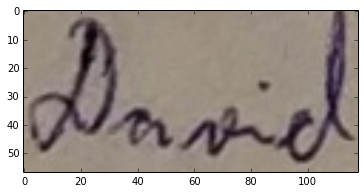

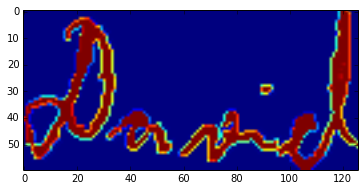

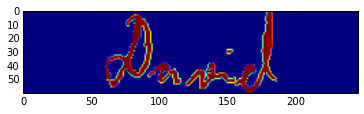

In [86]:
img = cv2.imread("./output/words/watershed/63.jpg")
implt(img)
img = imageNorm(img,60,border=False,tilt=True,hystNorm=True)
implt(img)
img = cv2.copyMakeBorder(img,0,0,60,60,cv2.BORDER_CONSTANT, value=[0,0,0])
implt(img)
gaps = segmentation(img, step=2, RNN=True, debug=False)
print gaps

In [87]:
for i in range(0,(len(gaps)-1)):
    implt(img[0:60,gaps[i]:gaps[i+1]])

In [90]:
chars = []
for i in range(0,(len(gaps)-1)):
    char = img[0:60,gaps[i]:gaps[i+1]]
    char, dim = letterNorm(char, is_thresh=True, dim=True)
    if dim[0]>4 and dim[1]>4:
        chars.append(char.flatten())
chars = np.array(chars)
word = ''

if len(chars) != 0:
    pred = charClass.run(chars)
    for c in pred:
        word += idx2char(c)
        
print word

David


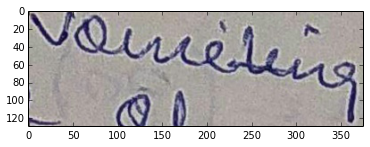

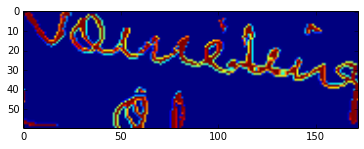

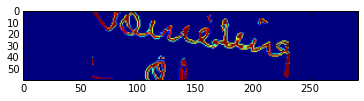

[59, 77, 103, 130, 149, 165, 180, 194, 204, 231]


In [118]:
img = cv2.imread("./output/words/watershed/32.jpg")
implt(img)
img = imageNorm(img,60,border=False,tilt=True,hystNorm=True)
implt(img)
img = cv2.copyMakeBorder(img,0,0,60,60,cv2.BORDER_CONSTANT, value=[0,0,0])
implt(img)
gaps = segmentation(img, step=2, RNN=False, debug=False)
print gaps

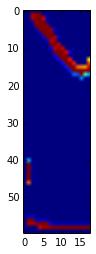

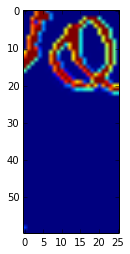

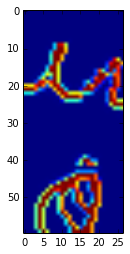

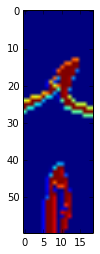

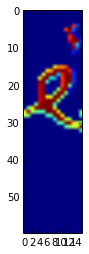

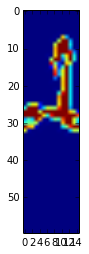

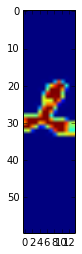

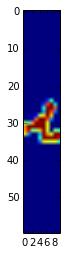

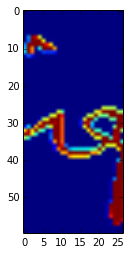

In [119]:
for i in range(0,(len(gaps)-1)):
    implt(img[0:60,gaps[i]:gaps[i+1]])

In [120]:
chars = []
for i in range(0,(len(gaps)-1)):
    char = img[0:60,gaps[i]:gaps[i+1]]
    char, dim = letterNorm(char, is_thresh=True, dim=True)
    if dim[0]>4 and dim[1]>4:
        chars.append(char.flatten())
chars = np.array(chars)
word = ''

if len(chars) != 0:
    pred = charClass.run(chars)
    for c in pred:
        word += idx2char(c)
        
print word

coaeedeeg
